In [1]:
using MAT
using Plots
using Images

include("./unmixing.jl");

In [2]:
pyplot()
filename = "../project_data.mat"
file = matopen(filename)
img = read(file, "im")
sources = read(file,"sources")
rgb = read(file,"rgb")
close(file)

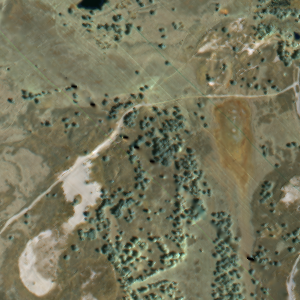

In [3]:
# visualize data in rgb (using bands 67,109,141 as th RGB channels)
p1 = colorview(RGB, permutedims(rgb,(3,1,2))) # convert 3d array to the image format used by julia

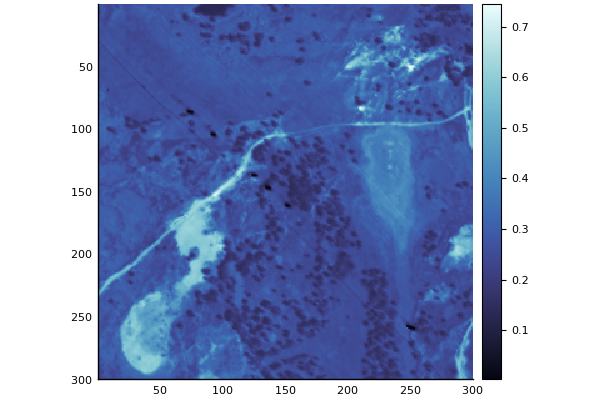

In [4]:
#visualize a spectral band on its own
p2 = heatmap(img[:,:,150],aspect_ratio=1, yflip = true,c=:ice)

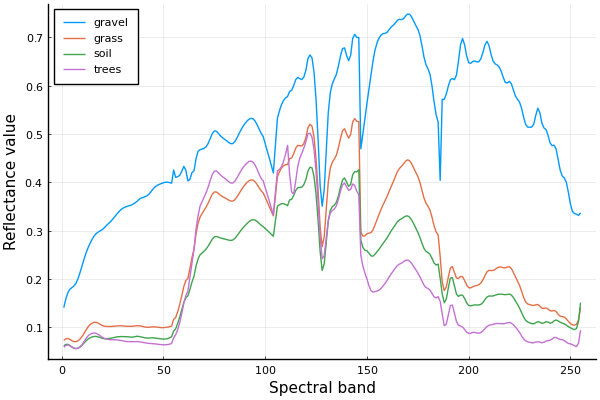

In [3]:
# visualize the endmembers to be used

plot(sources[:,1],label = "gravel")
plot!(sources[:,2],label = "grass")
plot!(sources[:,3],label = "soil")
plot!(sources[:,4],label = "trees")
xlabel!("Spectral band")
ylabel!("Reflectance value")

## Unmixing the image

The model we are using to decompose the image into the sum of the contributions of the endmembers is:

\begin{equation*}
\mathbf{X} = \mathbf{S}\mathbf{A} + \mathbf{E} 
\end{equation*}

 $\mathbf{X}\in \mathbb{R}^{L\times N}$ : data matrix
 
 $\mathbf{S}\in \mathbb{R}^{L\times P}$ : endmember matrix
 
 $\mathbf{A}\in \mathbb{R}^{P\times N}$ : abundance matrix
 
 $\mathbf{E}\in \mathbb{R}^{L\times N}$ : additive noise matrix
 
 where $L$ is the number of spectral bands, $P$ is the number of materials, and $N$ is the number of pixels
 
 The hyperspectral image is represented as a matrix with $N$ pixels, so the first thing to do is to reshape the image to a big matrix.

We can try and estimate the abundance matrix using a least squares formulation:

\begin{equation*}
\hat{A} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2}||\mathbf{X}-\mathbf{SA}||_{F}^{2} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2} \sum_{i=1}^{N} ||\mathbf{x}_{n}-\mathbf{S}\mathbf{a}_{n}||_{2}^{2}
\end{equation*}

where $\mathbf{1}_{.}$ is a vector of ones whose size is given in index 

Choose an algorithm to solve the optimization problem, and implement it both in a serial version and a version parallelized across the pixels.

In [220]:
n = 100^2
p = 4
l = 255
k = floor(Int, sqrt(n))

# Use a small crop of the image first
offset_x = 150
offset_y = 1
img_small = img[offset_x:offset_x + k - 1,offset_y:offset_y + k - 1, :]

X = img_small
S = sources;

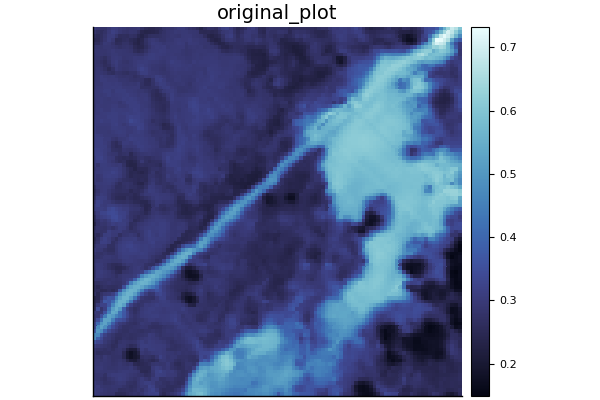

In [210]:
original_plot = heatmap(
    X[:, :, 150], title="original_plot", aspect_ratio=1, yflip = true, c=:ice, grid=false, ticks=false
)

# Projected Gradient (single constraint)

In [182]:
new_X_1c, A_1c, mean_loss_1c = estimate_abundance_pixel(X, S, "projected_gradient_1c");

In [183]:
n_pixels, time_1c = get_runtime_series(X, S, "projected_gradient_1c", "serial_pixel");

In [184]:
pg_1c_plot = heatmap(
    new_X_1c[:, :, 150], title="projected_gradient_1c", 
    aspect_ratio=1, yflip = true, c=:ice, grid=false, ticks=false
);

# Projected Gradient (two constraints)

In [185]:
new_X_2c, A_2c, mean_loss_2c = estimate_abundance_pixel(X, S, "projected_gradient_2c");

In [186]:
n_pixels, time_2c = get_runtime_series(X, S, "projected_gradient_2c", "serial_pixel");

In [187]:
pg_2c_plot = heatmap(
    new_X_2c[:, :, 150], title="projected_gradient_2c", 
    aspect_ratio=1, yflip = true, c=:ice, grid=false, ticks=false
);

# Log-barrier method

In [8]:
@time new_X_lb, A_lb, mean_loss_lb, loss = estimate_abundance(X, S, "log_barrier");

 22.284769 seconds (45.13 M allocations: 18.225 GiB, 15.25% gc time)


In [10]:
n_pixels, time_lb = get_runtime_series(X, "log_barrier")

([1, 6, 11, 16, 21, 27, 32, 37, 42, 47, 53, 58, 63, 68, 73, 79, 84, 89, 94, 100], Any[0.0047771, 0.0514645, 0.1672705, 0.307445899, 0.6397631, 0.914157701, 1.5090421, 2.1633905, 2.3764789, 2.754380701, 4.543166701, 5.0708313, 6.3000644, 8.8314415, 9.7343701, 12.9308331, 12.712927501, 14.3738875, 13.9365774, 15.4289771])

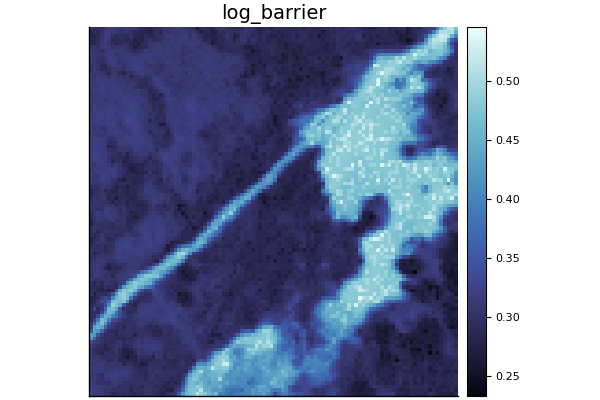

In [9]:
lb_plot = heatmap(
    new_X_lb[:, :, 150], title="log_barrier", 
    aspect_ratio=1, yflip = true,c=:ice, grid=false, ticks=false
)

# Interior Point Least Square (image-based)

In [233]:
include("./unmixing.jl");
@time new_X_ipls, A_ipls, loss_ipls = estimate_abundance_image(X, S, "ipls");

α1 0.2574000000000001
0
α2 0.2574000000000001

α1 0.35640000000000016
0
α2 0.35640000000000016

α1 0.2871000000000001
148
α2 1.3042212359079413e-15

α1 0.2871000000000001
153
α2 4.273672145823143e-16

α1 0.2871000000000001
160
α2 8.962540087957299e-17

α1 0.2871000000000001
150
α2 8.347015909810825e-16

α1 0.2871000000000001
150
α2 8.347015909810825e-16

α1 0.2871000000000001
150
α2 8.347015909810825e-16

α1 0.2871000000000001
153
α2 4.273672145823143e-16

α1 0.2871000000000001
155
α2 2.735150173326812e-16

α1 0.2871000000000001
146
α2 2.0378456811061583e-15

α1 0.2871000000000001
150
α2 8.347015909810825e-16

α1 0.2871000000000001
160
α2 8.962540087957299e-17

α1 0.2871000000000001
153
α2 4.273672145823143e-16

α1 0.2871000000000001
150
α2 8.347015909810825e-16

α1 0.2871000000000001
150
α2 8.347015909810825e-16

α1 0.2871000000000001
150
α2 8.347015909810825e-16

α1 0.2871000000000001
150
α2 8.347015909810825e-16

α1 0.2871000000000001
153
α2 4.273672145823143e-16

α1 0.2871000000000

LoadError: InterruptException:

In [192]:
n_pixels, time_ipls = get_runtime_series(X, S, "ipls", "serial_image", 4);

LoadError: DimensionMismatch("new dimensions (3, 25) must be consistent with array size 3")

In [219]:
loss_ipls

500-element Array{Float64,1}:
 17.401094282595565
 17.401094282595533
 17.4010942825955
 17.401094282595466
 17.401094282595356
 17.40109428259524
 17.401094282595228
 17.401094282595228
 17.401094282595228
 17.401094282595228
 17.401094282595228
 17.401094282595228
 17.401094282595228
  ⋮
 17.401094282595214
 17.401094282595214
 17.401094282595214
 17.401094282595214
 17.401094282595214
 17.401094282595214
 17.401094282595214
 17.401094282595214
 17.401094282595214
 17.401094282595214
 17.401094282595214
 17.401094282595214

In [215]:
ipls_plot = heatmap(
    new_X_ipls[:, :, 150], title="ipls", 
    aspect_ratio=1, yflip = true,c=:ice, grid=false, ticks=false
);

# Model Comparison

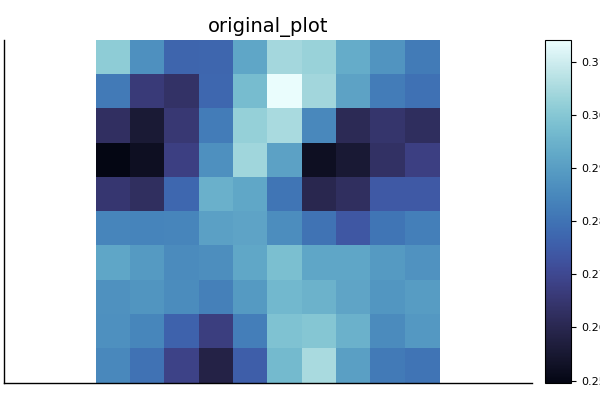

In [216]:
plot(original_plot)

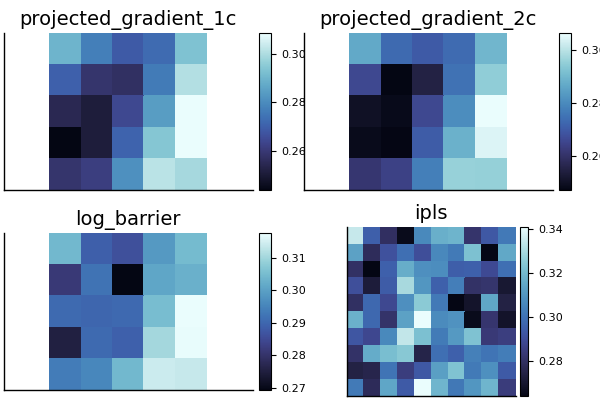

In [217]:
p = plot(pg_1c_plot, pg_2c_plot, lb_plot, ipls_plot, layout=(2, 2))

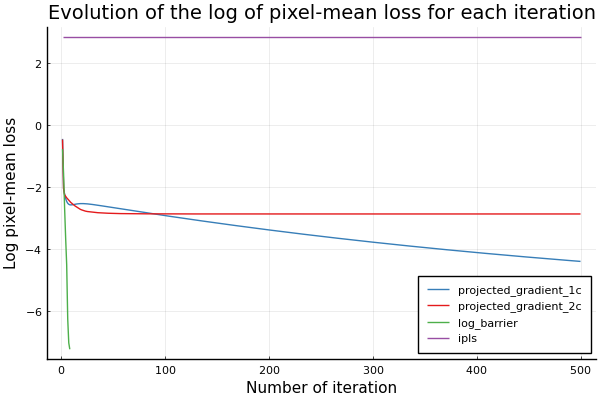

In [218]:
plot(
    log.(mean_loss_1c[mean_loss_1c .> 0]),
    title="Evolution of the log of pixel-mean loss for each iteration",
    ylabel = "Log pixel-mean loss", 
    xlabel = "Number of iteration", 
    label="projected_gradient_1c",
    color="#377eb8"
    
)
plot!(
    log.(mean_loss_2c[mean_loss_2c .> 0]),
    label="projected_gradient_2c",
    color="#e41a1c"
)
plot!(
    log.(mean_loss_lb[mean_loss_lb .> 0]),
    label="log_barrier",
    color="#4daf4a"
)
plot!(
    log.(loss_ipls[loss_ipls .> 0]),
    label="ipls",
    color="#984ea3"
)

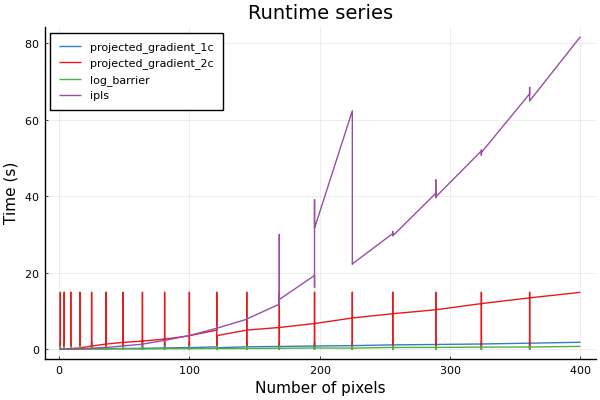

In [23]:
n_pixels2 = [k^2 for k = n_pixels]
plot(
    n_pixels2, time_1c,
    title="Runtime series",
    ylabel = "Time (s)", 
    xlabel = "Number of pixels", 
    label="projected_gradient_1c",
    color="#377eb8"
    
)
plot!(
    n_pixels2, time_2c,
    label="projected_gradient_2c",
    color="#e41a1c"
)
plot!(
    n_pixels2, time_lb,
    label="log_barrier",
    color="#4daf4a"
)
plot!(
    n_pixels2, time_ipls,
    label="ipls",
    color="#984ea3"
)

# Parallel programming

In [11]:
#rmprocs(procs()[2:end])
procs()

1-element Array{Int64,1}:
 1

In [12]:
#Choosing the number of processors to add
addprocs(1)

#Define S matrix for each processor
filename = "../project_data.mat"
file = matopen(filename)
img = read(file, "im")
sources = read(file,"sources")
rgb = read(file,"rgb")
close(file)
S=sources;

#Define the needed function on all processors
@everywhere include("./unmixing.jl") 

In [13]:
@time X_parallel_lb=parallel_estimate_abundance(X,S,"log_barrier");

 19.627207 seconds (2.94 M allocations: 213.122 MiB)


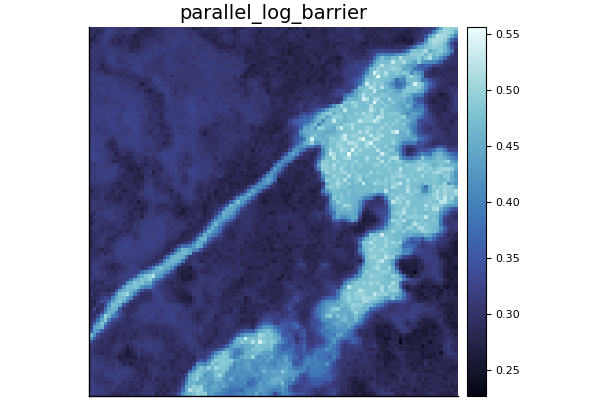

In [14]:
parallel_plot = heatmap(
    X_parallel_lb[:, :, 150], title="parallel_log_barrier", 
    aspect_ratio=1, yflip = true,c=:ice, grid=false, ticks=false
)

In [15]:
n_pixels, time_parallel_lb = get_runtime_series(X, "log_barrier","parallel_estimator");

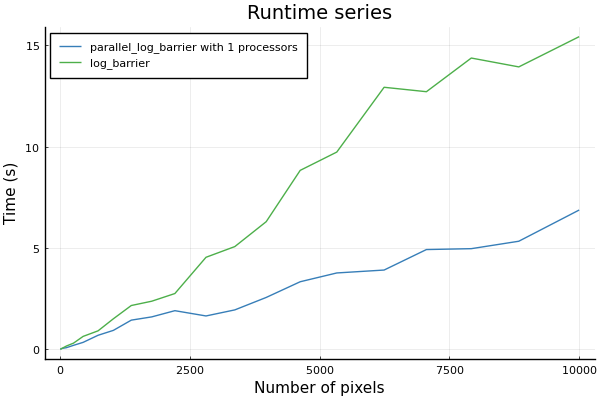

In [129]:
n_pixels2 = [k^2 for k = n_pixels]
plot(
    n_pixels2, time_parallel_lb,
    title="Runtime series",
    ylabel = "Time (s)", 
    xlabel = "Number of pixels", 
    label=string("parallel_log_barrier with ",string(nprocs())," processors"),
    color="#377eb8"    
)
plot!(
    n_pixels2, time_lb,
    label="log_barrier",
    color="#4daf4a"
)

In [ ]:
rmprocs(procs()[2:end])

In [82]:
time_series_parallel=Dict()
for i=1:3
    addprocs(i)
    #Define S matrix for each processor
    filename = "../project_data.mat"
    file = matopen(filename)
    img = read(file, "im")
    sources = read(file,"sources")
    rgb = read(file,"rgb")
    close(file)
    S=sources;

    #Define the needed function on all processors
    @everywhere include("./unmixing.jl") 
    n_pixels, time_series_parallel[i+1] = get_runtime_series(X, "log_barrier","parallel_estimator")
end

In [123]:
time_series_parallel

Dict{Any,Any} with 3 entries:
  4 => Any[0.368692, 4.10657, 0.0391812, 0.103088, 0.135066, 0.267954, 0.468588…
  2 => Any[3.05493, 0.0550838, 0.142325, 0.311825, 0.53291, 0.825317, 1.14929, …
  3 => Any[0.352203, 3.40672, 0.0546009, 0.116941, 0.188808, 0.333913, 0.447753…

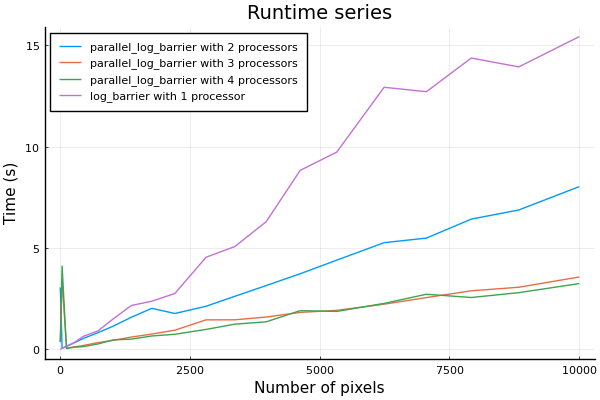

In [147]:
n_pixels2 = [k^2 for k = n_pixels]

plot()

for i=1:length(time_series_parallel)
    plot!(
        n_pixels2, time_series_parallel[i+1],
        title="Runtime series",
        ylabel = "Time (s)", 
        xlabel = "Number of pixels", 
        label=string("parallel_log_barrier with ",string(i+1)," processors")
    )
end


plot!(n_pixels2, time_lb,
    label="log_barrier with 1 processor",
    ylabel = "Time (s)", 
    xlabel = "Number of pixels", 
)


In [148]:
rmprocs(procs()[2:end])
procs()

1-element Array{Int64,1}:
 1